# Likelihood-Free Inference with PyVBMC
Likelihood-free inference, a type of Approximate Bayesian Computation, is a potentially useful approach when data $d_{\theta}$ can be readily obtained from the parameters, but the likelihood $L(\theta) = p(d | \theta)$ is unknown or intractable. A common version approximates the likelihood of $\theta$ by a uniform distribution over a related quantity,
$$\hat{L}_{\epsilon}(\delta_{\theta}) = \mathrm{Unif}(\delta_{\theta} ; 0, \epsilon) \,,$$
where $\delta_{\theta} = \rho\big(s(d_{\theta}),\, s(d_{obs}) \big)$ is some discrepancy measure between the generated and observed data. For example, $\rho$ may be distance between the data themselves, or a discrepancy between lower dimensional summary statistics $s$ of the data.

Here we demonstrate using PyVBMC for inference without a known likelihood, by constructing a pseudo-likelihood from a specified forward simulation and summary statistic. The ideal pseudo-likelihood should be continuous with a somewhat heavy tail in order to behave nicely with PyVBMC, so we provide a utility function `pseudo_likelihood`, which takes as input a simulation function `sim_fun` and a discrepancy threshold `epsilon`, and returns a callable pseudo-likelihood such that most of the probability mass of $\delta$ lies within $(0, \epsilon)$, with a Student's t-shaped tail for the remaining mass.

The example problem is to estimate the angular velocity $\theta$ and decay rate $\lambda$ of a damped oscillator whose amplitude is given by
$$ A(t) = e^{-\lambda t} \, \cos(\omega \, t)\,. $$

In [1]:
"""Setup"""
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
plt.rcParams['figure.figsize'] = (10, 7.5)
from pyvbmc.likelihood_free import pseudo_likelihood
from pyvbmc.vbmc import VBMC
np.random.seed(42)

In [2]:
"""Forward Model"""
D = 2  # Problem dimension
omega_true = 2 * np.pi  # Angular frequency
lambda_true = 0.5  #  Decay rate
theta_true = (omega_true, lambda_true)

t_grid = np.linspace(0, np.pi/2, num=10)  # Observed time points
plt_grid = np.linspace(0, np.pi/2, num=100)  # For visualization

def simulation(theta, grid=t_grid):
    omega, lambd = theta
    return np.exp(-lambd * grid) * np.cos(omega * grid)
d_obs = simulation(theta_true) + sps.norm.rvs(scale=0.05, size=10)  # Observation noise

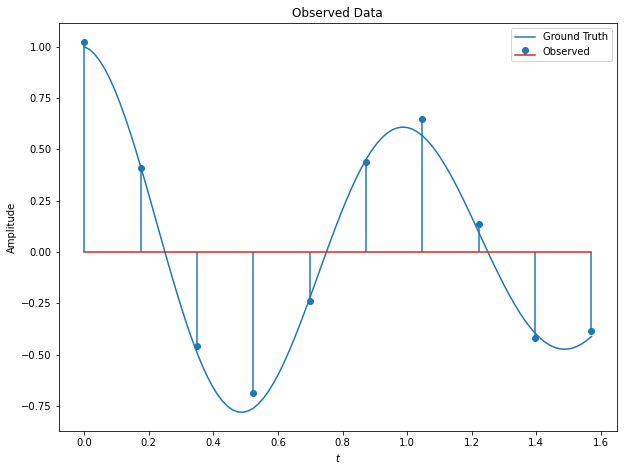

In [3]:
plt.plot(plt_grid, simulation((theta_true), plt_grid), label="Ground Truth")
plt.stem(t_grid, d_obs, label="Observed")
plt.title("Observed Data")
plt.xlabel(r"$t$")
plt.ylabel("Amplitude")
plt.legend();

Note that because the data generating process is deterministic, with only additive Gaussian noise on the observed data, the likelihood in this case is in fact very tractable, and there is really no need for likelihood-free inference here. However, it will suffice for purposes of illustration.

For the `psuedo-likelihood` function, `epsilon` is a required argument, since the discrepancy is arbitrary and there is no natural "default" scale. A potential method to choose `epsilon` is to sample $\theta$ from its prior distribution and take some small quantile of the resulting discrepancy $\delta_{\theta}$.

In [17]:
"""Pseudo-Likelihood"""
epsilon = 0.2
a = 0.9  # The default
p = 0.99  # The default
distance = lambda dt, do: np.linalg.norm(dt - do)  # The default
summary = lambda d: d  # The default
ll, ll_plot = pseudo_likelihood(
    simulation,
    epsilon,
    data=d_obs,
    distance=distance,
    summary=summary,
    a=a,
    p=p,
    return_plot_fun=True
)

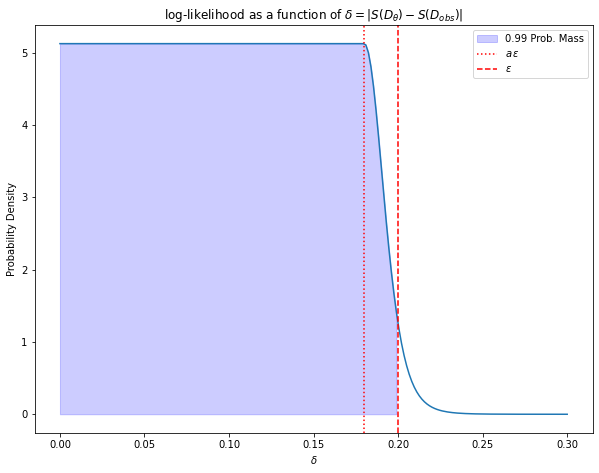

In [18]:
delta = np.linspace(0,0.3,200)
ll_delta = np.exp(np.array([ll_plot(di) for di in delta]))
plt.plot(delta, ll_delta);
plt.fill_between(
        x=delta, 
        y1=np.exp(ll_plot(delta)), 
        where=(0 <= delta) & (delta <= epsilon),
        color="b",
        alpha=0.2,
        label=f"{p} Prob. Mass"
);
plt.axvline(x=a*epsilon, color="r", linestyle="dotted", label=r"$a \, \epsilon$");
plt.axvline(x=epsilon, color="r", linestyle="dashed", label=r"$\epsilon$");
plt.title(r"log-likelihood as a function of $\delta = |S(D_{\theta}) - S(D_{obs})|$");
plt.xlabel(r"$\delta$");
plt.ylabel("Probability Density");
plt.legend(loc="upper right");

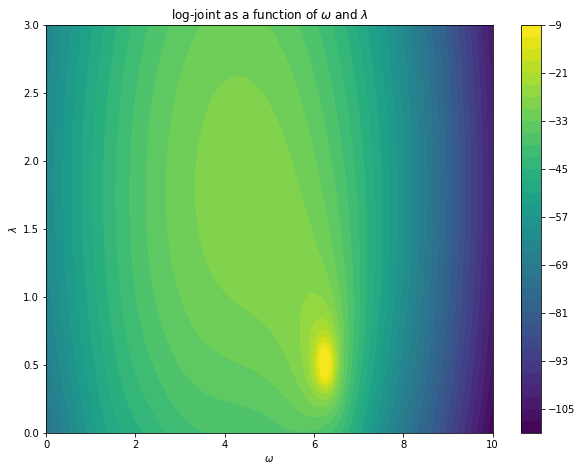

In [6]:
"""Full Model"""
def ltarget(theta):  # Pseudo-likelihood + (slightly misspecified) prior
    theta = np.atleast_2d(theta)
    omega = theta[:, 0]
    lambd = theta[:, 1]
    return ll(theta) + sps.norm.logpdf(omega, loc=4, scale=0.5) + sps.norm.logpdf(lambd, loc=1.5, scale=0.5)

M = 100
xlist = np.linspace(0, 10, M)
ylist = np.linspace(0, 3, M)
X, Y = np.meshgrid(xlist, ylist)
thetas = np.vstack([X.ravel(), Y.ravel()]).T
Z = ltarget(thetas).reshape(M,M)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z, levels=35)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title(r"log-joint as a function of $\omega$ and $\lambda$")
ax.set_xlabel(r"$\omega$")
ax.set_ylabel(r"$\lambda$")
plt.show();

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10         -24.40         5.16    129749.03        2        inf     start warm-up


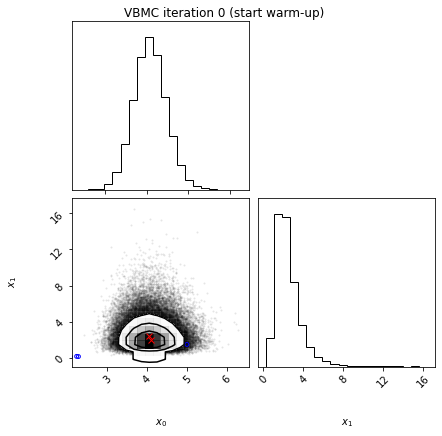

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     1         15         -27.58         0.09         2.63        2        inf     


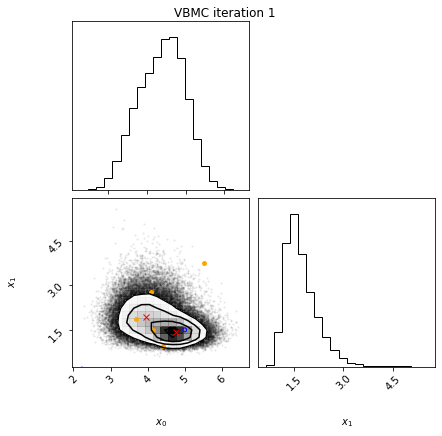

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     2         20         -27.40         0.11         0.12        2       3.69     


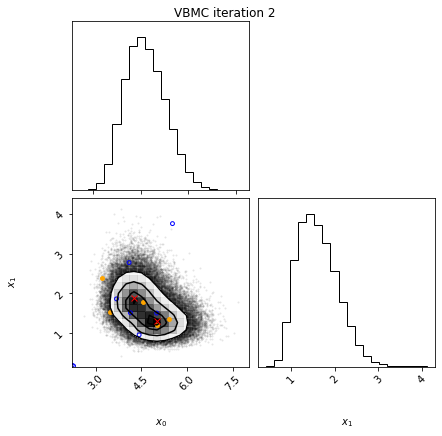

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     3         25         -21.12         0.98         1.34        2       55.7     


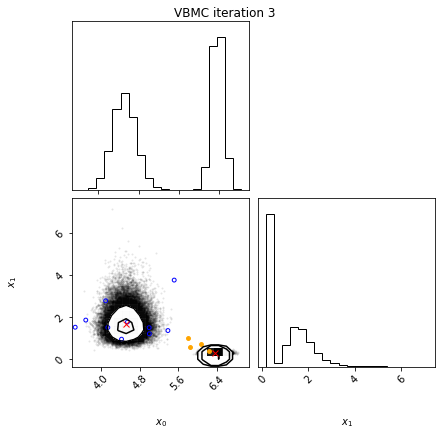

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     4         30         -22.08         1.71         0.24        2       14.6     


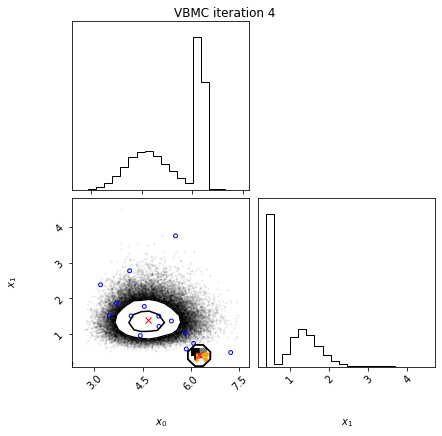

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     5         35         -24.20         1.40         0.76        2       29.7     


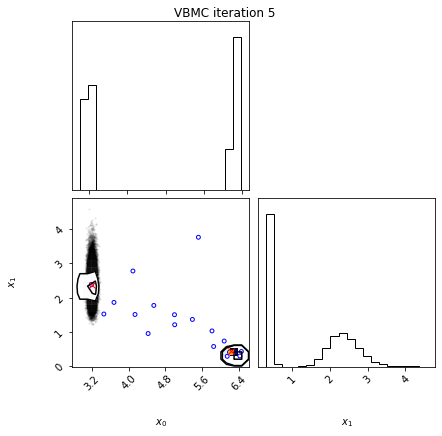

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     6         40         -21.72         0.71         3.61        2       95.8     


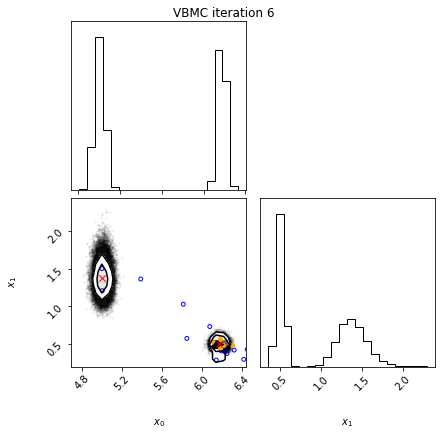

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     7         45         -21.28         1.17       110.83        2   2.62e+03     


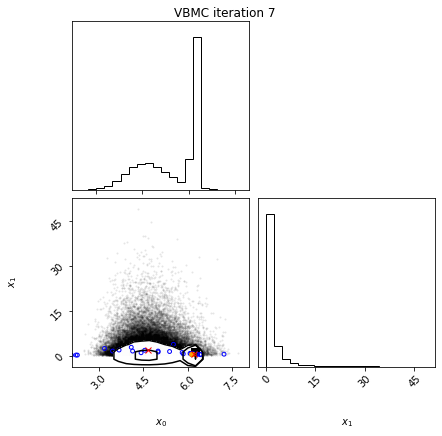

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     8         50         -29.71         2.21         9.08        2        238     


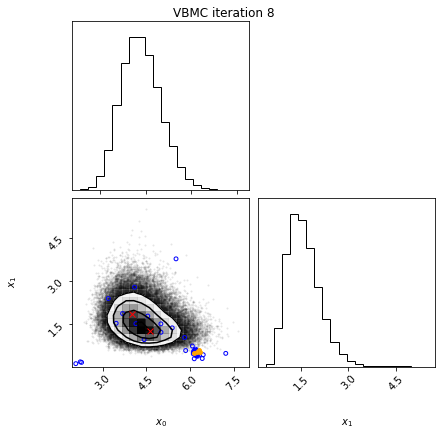

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     9         55         -28.98         2.29         0.38        2       15.7     


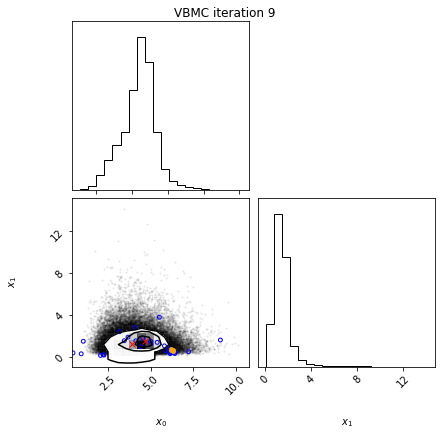

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    10         60         -21.41         1.59         1.98        2       69.6     


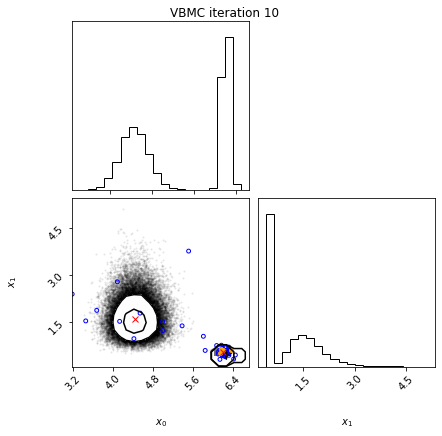

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    11         65         -14.57         0.08       123.42        2   2.93e+03     trim data


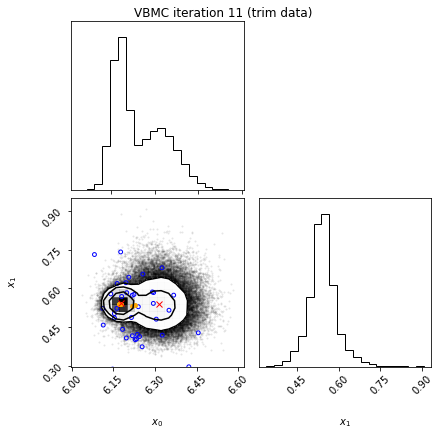

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    12         70         -21.52         1.60       131.32        2   3.12e+03     


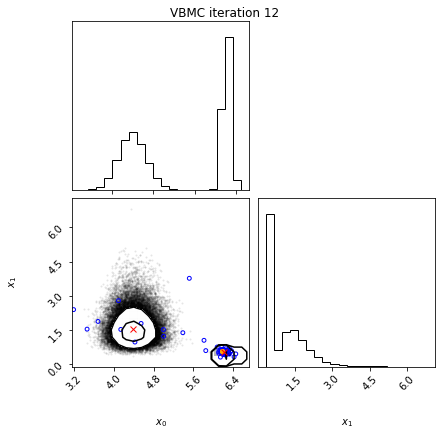

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    13         75         -27.90         3.44         2.79        2       92.8     end warm-up


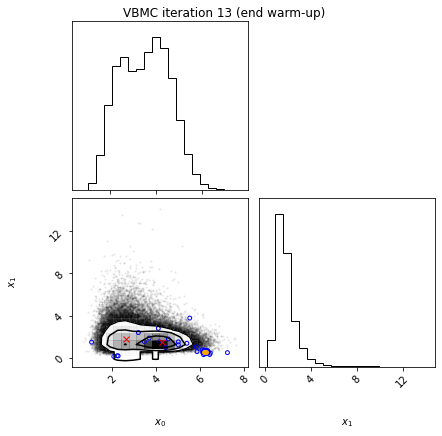

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    14         80         -13.98         0.03      1051.19        2   2.48e+04     


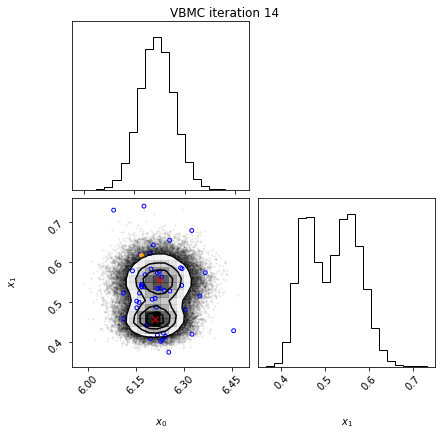

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    15         85         -13.97         0.01         0.02        2      0.547     


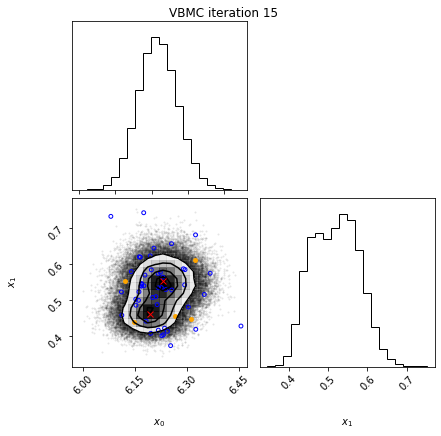

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    16         90         -13.85         0.01         0.05        5       1.57     


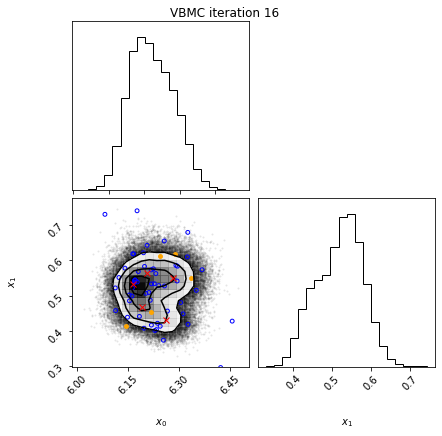

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    17         95         -13.81         0.02         0.00        6      0.209     rotoscale, undo


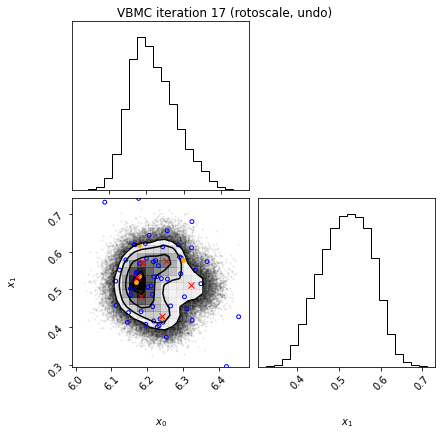

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    18        100         -13.79         0.00         0.00        9      0.166     


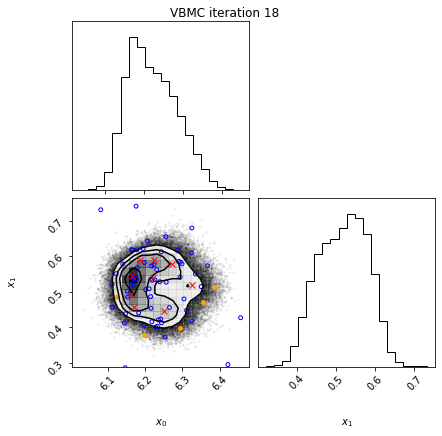

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    19        105         -13.78         0.03         0.01       11      0.212     


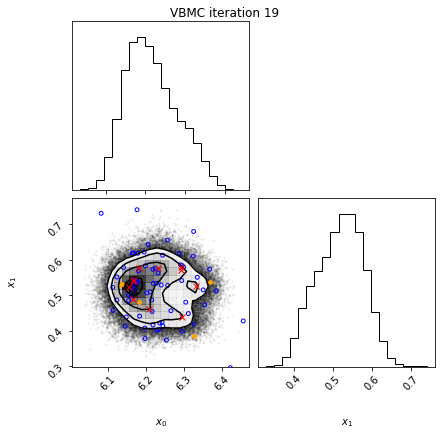

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    20        110         -13.78         0.03         0.00       11       0.11     


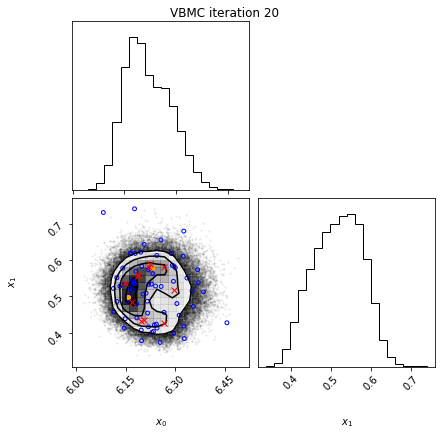

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    21        115         -13.78         0.01         0.01       11      0.203     


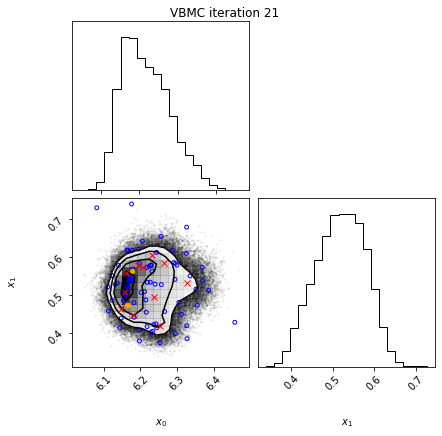

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    22        120         -13.76         0.03         0.01       12      0.244     


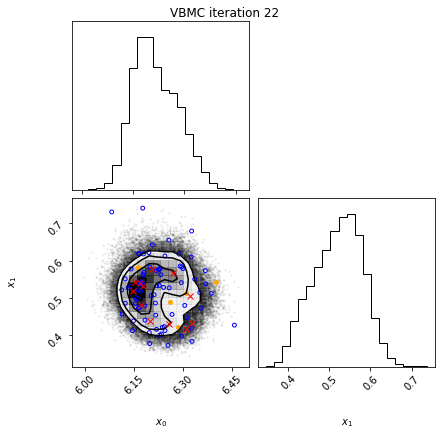

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    23        125         -13.77         0.03         0.00       11      0.104     


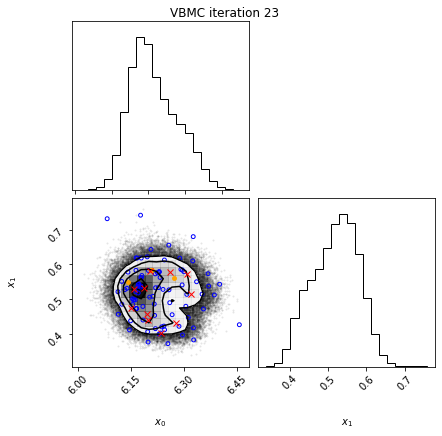

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    24        130         -13.80         0.02         0.00       11      0.218     


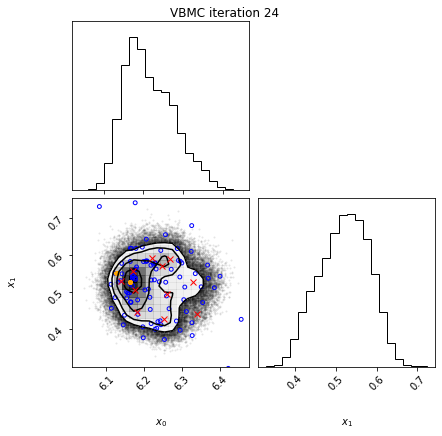

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    25        135         -13.79         0.00         0.00       11      0.147     stable


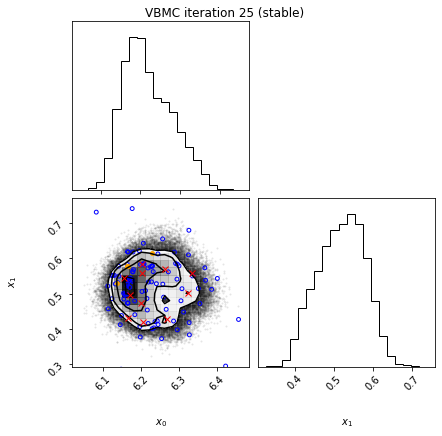

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
   inf        135         -13.74         0.00         0.00       50      0.147     finalize


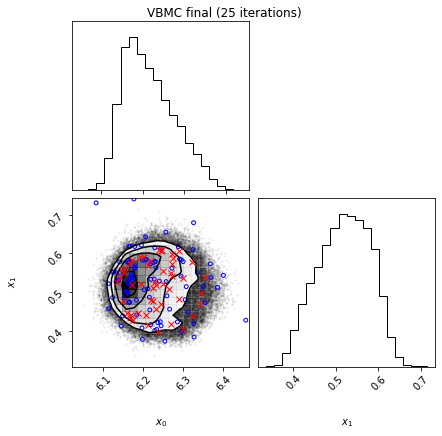

Inference terminated: variational solution stable for options.tolstablecountfcn evaluations.
Estimated ELBO: -13.740 +/-0.004.


In [7]:
"""Inference"""
x0 = np.array([[5.0, 1.5]])
lb = np.full((1, D), -np.inf)
ub = np.full((1, D), np.inf)
lb = np.array([[0.0, 0.0]])
ub = np.array([[20.0, 60.0]])
plb = np.array([[0.1, 0.1]])
pub = np.array([[10.0, 3.0]])
options = {
    #"searchacqfcn": ["@acqviqr_vbmc"],
    "plot": True,
}
vbmc = VBMC(ltarget, x0, lb, ub, plb, pub, user_options=options)
vp, elbo, elbo_sd, _, _ = vbmc.optimize()

After inference has completed we can sample from the resulting posterior and check the results:

In [28]:
"""Posterior Checks"""
samples = vp.sample(100)[0]
print( "                [omega      lambda    ]")
print( "---------------------------------------")
print(f"  Ground Truth: {np.array([omega_true, lambda_true])}")
print(f"Posterior Mean: {np.mean(samples, axis=0)}")

                [omega      lambda    ]
---------------------------------------
  Ground Truth: [6.28318531 0.5       ]
Posterior Mean: [6.21601084 0.51878348]


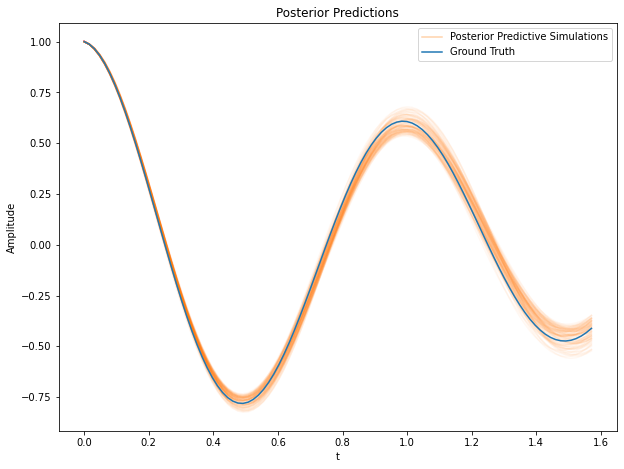

In [9]:
for s in samples:
    plt.plot(plt_grid, simulation(s, plt_grid), alpha=0.05, color="tab:orange")
plt.plot([], [], alpha=0.35, color="tab:orange", label="Posterior Predictive Simulations")
plt.plot(plt_grid, simulation(theta_true, plt_grid), color="tab:blue", label="Ground Truth")
plt.title(r"Posterior Predictions")
plt.xlabel(r"t")
plt.ylabel(r"Amplitude")
plt.legend();